# Forest Cover Type Classification Analysis

In [83]:
#pre-processing:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#modeling:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#testing and calibrating

from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

#visualization
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
#load training and test sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [20]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [22]:
#convert all columns to lower case
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]

In [18]:
#access balance in the training set
train.groupby('cover_type')['id'].count()

cover_type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: id, dtype: int64

In [23]:
#set id as the index in both datat sets
train.set_index('id',inplace=True)
test.set_index('id',inplace=True)

In [29]:
#split training into X and Y
y_train = train['cover_type']
x_train = train.iloc[:,:-1]

In [38]:
#since we don't have labels on our test data we need to split the training data to access model ability
x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=13)

In [39]:
#set parameter range for grid search
rf_para = [{'n_estimators':[50, 200], 'max_depth':range(5,20), 'max_features':[0.1, 0.5],
           'min_samples_leaf':[1,3],'bootstrap':[True,False]}]

In [40]:
#run a grid search cv to 
rfc = GridSearchCV(RandomForestClassifier(), param_grid=rf_para, cv = 10, n_jobs=-1)
rfc.fit(x_tr, y_tr)
print(rfc.best_params_)

{'n_estimators': 200, 'bootstrap': False, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 19}


In [43]:
#print best accuracy score obtained
print("Best accuracy score reported: {}".format(rfc.best_score_))

Best accuracy score reported: 0.8645006613756614


In [44]:
#run random forest classifier on 
rfc = RandomForestClassifier(n_estimators=200, max_depth=19, max_features=0.3, bootstrap=False, min_samples_leaf=1,
                             n_jobs=-1)

rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=19, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
train_sizes, train_scores, test_scores = learning_curve(rfc, 
                                                        x_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=ShuffleSplit(n_splits=50, test_size=0.2,random_state=13),
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.1, 1, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

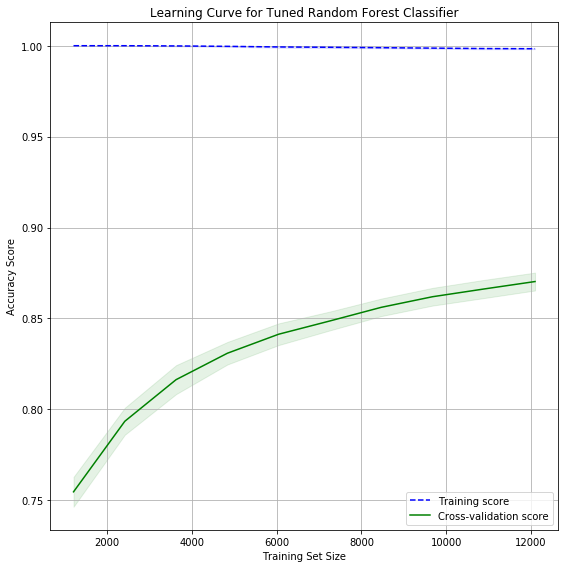

In [62]:
#initialize Learning Curve Plot

plt.figure(figsize=(8,8))

# Draw lines
plt.plot(train_sizes, train_mean, '--', color='blue',  label="Training score")
plt.plot(train_sizes, test_mean, color='green', label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue",alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green",alpha=0.1)

# Create plot
plt.title("Learning Curve for Tuned Random Forest Classifier")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [66]:
print("matthews correlation coefficient on train data: {}".format(matthews_corrcoef(y_tr,rfc.predict(x_tr))))
print("matthews correlation coefficient on validation data: {}".format(matthews_corrcoef(y_val,rfc.predict(x_val))))

matthews correlation coefficient on train data: 0.9974002380799643
matthews correlation coefficient on validation data: 0.9980731043709345


### XGBoost Classifier

In [73]:
#initialize baseline XGBoost Classifier 
xgbc = XGBClassifier(silent=True,n_estimators=100,learning_rate=0.2,max_depth=10,gamma=0.5,
                    max_delta_step =1, min_child_weight=2, colsample_bytree =0.6, seed=13)

In [76]:
#set parameter search range
rf_para = [{'n_estimators':[50,100,150, 200], 'max_depth':[5,10,15,20], 'learning_rate':[0.05,0.1,0.2],
           'min_child_weight':[1,2,3]}]

In [77]:
grid2 = GridSearchCV(xgbc, param_grid=rf_para, cv =10, n_jobs=-1)
grid2.fit(x_tr, y_tr)
print(grid2.best_params_, grid2.best_score_)

{'n_estimators': 150, 'min_child_weight': 2, 'learning_rate': 0.1, 'max_depth': 20} 0.8636739417989417


In [86]:
#rerun model with tuned parameters
#x_tr, x_val, y_tr, y_val

xgbc = XGBClassifier(silent=True,n_estimators=300,learning_rate=0.1,max_depth=20,gamma=0.5,
                    max_delta_step =1, min_child_weight=2, colsample_bytree =0.6, seed=13)

In [87]:
# Calculating error
xgbc.fit(x_tr, y_tr)
pred = xgbc.predict(x_val)

accuracy = accuracy_score(y_val, pred)

In [85]:
#print accuracy score
print("xgboost accuracy: {}".format(accuracy))

xgboost accuracy: 0.8621031746031746


In [88]:
#print confusion matrix
print(confusion_matrix(y_val, pred))

[[326  73   1   0   4   2  35]
 [ 74 291   6   0  42  14   4]
 [  0   3 400  16   5  44   0]
 [  0   0   8 390   0  10   0]
 [  1  11   4   0 411   3   0]
 [  2   1  37   5   2 367   0]
 [ 11   1   0   0   0   0 420]]
